## scANVI analysis for healthy PBMC pilot study (Cai 2020 and Cai 2022)

**Objective**: Run scANVI analysis for label transfer for healthy PBMCs [Cai 2020 and Cai 2022]


- **Developed by**: Mairi McClean

- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**

- v230317



### Import modules 

In [1]:
import sys

from scvi_colab import install

install()

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install --quiet scrublet

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import sys
import warnings

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi


/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 94705


### Read in data

In [4]:
adata_ref = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/INBOX/sc_downloads/yoshida_2021/meyer_nikolic_covid_pbmc.cellxgene.20210813.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 422220 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [5]:
adata_ref.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.359517
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.577522
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Male,Non-smoker,AN3,CV001_KM10202384-CV001_KM10202394,0.369143
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.785563
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.564174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S28_TTTGTCAGTTCTGTTT-1,PC9,EUR,27.17,NK,NK,NK,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.429398
S28_TTTGTCATCAACCAAC-1,PC9,EUR,27.17,Monocyte,Monocyte CD14,Classical monocyte,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.677910
S28_TTTGTCATCATTATCC-1,PC9,EUR,27.17,Monocyte,Monocyte CD14,Classical monocyte,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.422796
S28_TTTGTCATCCTATGTT-1,PC9,EUR,27.17,DC,pDC,pDC,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.471905


In [6]:
adata_ref.var

,name
MIR1302-2HG,MIR1302-2HG
FAM138A,FAM138A
OR4F5,OR4F5
AL627309.1,AL627309.1
AL627309.3,AL627309.3
...,...
AB-TRAC,AB-TRAC
AB-TRG,AB-TRG
AB-TIGIT,AB-TIGIT
AB-CRLF2,AB-CRLF2


#### Filter query dataset to online include healthy cells

In [7]:
adata_ref.obs['COVID_status'].value_counts()

Healthy          173684
COVID-19         151312
Post-COVID-19     97224
Name: COVID_status, dtype: int64

In [8]:
adata_ref_new = adata_ref[~adata_ref.obs['COVID_status'].isin(['COVID-19', 'Post-COVID-19']),:]
adata_ref_new

View of AnnData object with n_obs × n_vars = 173684 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [9]:
adata_ref_new.obs['COVID_status'].value_counts()

Healthy    173684
Name: COVID_status, dtype: int64

In [10]:
sc.pp.filter_genes(adata_ref_new, min_counts=3)

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


In [11]:
adata_query = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/processed_files/scvi/post_sccaf/CaiY_healthy_scRNA_PBMC_mm230316_scVI-clustered.raw.h5ad')


### Train reference

> From tutorial: SCANVI tends to perform better in situations where it has been initialized using a pre-trained SCVI model. 

Reference anndata must be processed in the same way as the query object (in the previous step). E.g. HVG (and normalisation?), and saving the counts layer

In [12]:
adata_ref_new.layers["counts"] = adata_ref_new.X.copy()

In [13]:
# Note: For best practices of how/when to perform feature selection, 
# please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

sc.pp.highly_variable_genes(
    adata_ref_new,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sequencing_library",
)

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [14]:
# Added for sarches params following tutorial; check if we require it?
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

In [15]:
scvi.model.SCVI.setup_anndata(adata_ref_new, batch_key="sequencing_library", layer="counts")

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [17]:
# What do the "**" mean here?

scvi_ref_new_model = scvi.model.SCVI(adata_ref_new, **arches_params)
scvi_ref_new_model.train()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/46:   0%|          | 0/46 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/46:   2%|▏         | 1/46 [01:00<45:20, 60.45s/it, loss=392, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/46:   4%|▍         | 2/46 [02:00<44:02, 60.06s/it, loss=386, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/46:   7%|▋         | 3/46 [02:59<42:52, 59.81s/it, loss=378, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/46:   9%|▊         | 4/46 [03:58<41:42, 59.58s/it, loss=374, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/46:  11%|█         | 5/46 [04:58<40:39, 59.51s/it, loss=371, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/46:  13%|█▎        | 6/46 [05:58<39:44, 59.61s/it, loss=374, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/46:  15%|█▌        | 7/46 [06:59<39:05, 60.14s/it, loss=367, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/46:  17%|█▋        | 8/46 [07:59<38:02, 60.05s/it, loss=367, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/46:  20%|█▉        | 9/46 [08:59<37:02, 60.08s/it, loss=367, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/46:  22%|██▏       | 10/46 [09:59<36:03, 60.09s/it, loss=367, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/46:  24%|██▍       | 11/46 [11:00<35:08, 60.25s/it, loss=365, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/46:  26%|██▌       | 12/46 [12:00<34:10, 60.30s/it, loss=365, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/46:  28%|██▊       | 13/46 [13:01<33:15, 60.47s/it, loss=368, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/46:  30%|███       | 14/46 [14:03<32:28, 60.88s/it, loss=365, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/46:  33%|███▎      | 15/46 [15:04<31:29, 60.96s/it, loss=365, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/46:  35%|███▍      | 16/46 [16:05<30:28, 60.94s/it, loss=367, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/46:  37%|███▋      | 17/46 [17:05<29:25, 60.86s/it, loss=369, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/46:  39%|███▉      | 18/46 [18:09<28:44, 61.58s/it, loss=364, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/46:  41%|████▏     | 19/46 [19:11<27:49, 61.85s/it, loss=364, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/46:  43%|████▎     | 20/46 [20:11<26:33, 61.28s/it, loss=367, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/46:  46%|████▌     | 21/46 [21:13<25:37, 61.50s/it, loss=366, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/46:  48%|████▊     | 22/46 [22:20<25:12, 63.04s/it, loss=363, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/46:  50%|█████     | 23/46 [23:21<23:54, 62.38s/it, loss=366, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/46:  52%|█████▏    | 24/46 [24:21<22:40, 61.86s/it, loss=367, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/46:  54%|█████▍    | 25/46 [25:22<21:29, 61.39s/it, loss=367, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/46:  57%|█████▋    | 26/46 [26:22<20:23, 61.16s/it, loss=366, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/46:  59%|█████▊    | 27/46 [27:24<19:23, 61.24s/it, loss=361, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/46:  61%|██████    | 28/46 [28:24<18:16, 60.89s/it, loss=365, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/46:  63%|██████▎   | 29/46 [29:25<17:18, 61.07s/it, loss=366, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/46:  65%|██████▌   | 30/46 [30:28<16:23, 61.47s/it, loss=363, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/46:  67%|██████▋   | 31/46 [31:31<15:29, 62.00s/it, loss=368, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/46:  70%|██████▉   | 32/46 [32:33<14:27, 61.98s/it, loss=365, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/46:  72%|███████▏  | 33/46 [33:34<13:23, 61.80s/it, loss=361, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/46:  74%|███████▍  | 34/46 [34:34<12:15, 61.26s/it, loss=366, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/46:  76%|███████▌  | 35/46 [35:37<11:20, 61.85s/it, loss=368, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/46:  78%|███████▊  | 36/46 [36:38<10:15, 61.57s/it, loss=369, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/46:  80%|████████  | 37/46 [37:38<09:10, 61.13s/it, loss=366, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/46:  83%|████████▎ | 38/46 [38:39<08:07, 60.88s/it, loss=362, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/46:  85%|████████▍ | 39/46 [39:39<07:05, 60.83s/it, loss=371, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/46:  87%|████████▋ | 40/46 [40:39<06:02, 60.48s/it, loss=361, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/46:  89%|████████▉ | 41/46 [41:40<05:03, 60.65s/it, loss=364, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/46:  91%|█████████▏| 42/46 [42:41<04:02, 60.67s/it, loss=365, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/46:  93%|█████████▎| 43/46 [43:41<03:01, 60.52s/it, loss=362, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/46:  96%|█████████▌| 44/46 [44:42<02:01, 60.59s/it, loss=363, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/46:  98%|█████████▊| 45/46 [45:42<01:00, 60.61s/it, loss=363, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/46: 100%|██████████| 46/46 [46:42<00:00, 60.37s/it, loss=363, v_num=1]

`Trainer.fit` stopped: `max_epochs=46` reached.


Epoch 46/46: 100%|██████████| 46/46 [46:42<00:00, 60.93s/it, loss=363, v_num=1]


In [18]:
#For this part of the tutorial, we will create a new labels key in the reference anndata object to reflect 
# the common scenario of having no labels for the query data.
adata_ref_new.obs["labels_scanvi"] = adata_ref_new.obs["annotation_detailed"].values

In [19]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scanvi = scvi.model.SCANVI.from_scvi_model(
    scvi_ref_new_model,
    unlabeled_category="Unknown",
    labels_key="labels_scanvi",
)

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/_utils.py:172: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/_utils.py:172: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [22]:
vae_ref_scanvi.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/10:  10%|█         | 1/10 [02:42<24:22, 162.51s/it, loss=519, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/10:  20%|██        | 2/10 [05:34<22:26, 168.31s/it, loss=512, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/10:  30%|███       | 3/10 [08:25<19:45, 169.37s/it, loss=511, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/10:  40%|████      | 4/10 [11:11<16:49, 168.20s/it, loss=516, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/10:  50%|█████     | 5/10 [14:02<14:05, 169.05s/it, loss=514, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/10:  60%|██████    | 6/10 [16:50<11:15, 168.83s/it, loss=518, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/10:  70%|███████   | 7/10 [19:44<08:31, 170.51s/it, loss=511, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/10:  80%|████████  | 8/10 [22:42<05:45, 172.85s/it, loss=511, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/10:  90%|█████████ | 9/10 [25:35<02:52, 172.79s/it, loss=514, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/10: 100%|██████████| 10/10 [28:33<00:00, 174.51s/it, loss=511, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [28:33<00:00, 171.37s/it, loss=511, v_num=1]


In [23]:
adata_ref_new.obsm["X_scANVI"] = vae_ref_scanvi.get_latent_representation()
sc.pp.neighbors(adata_ref_new, use_rep="X_scANVI")
sc.tl.leiden(adata_ref_new)
sc.tl.umap(adata_ref_new)


/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


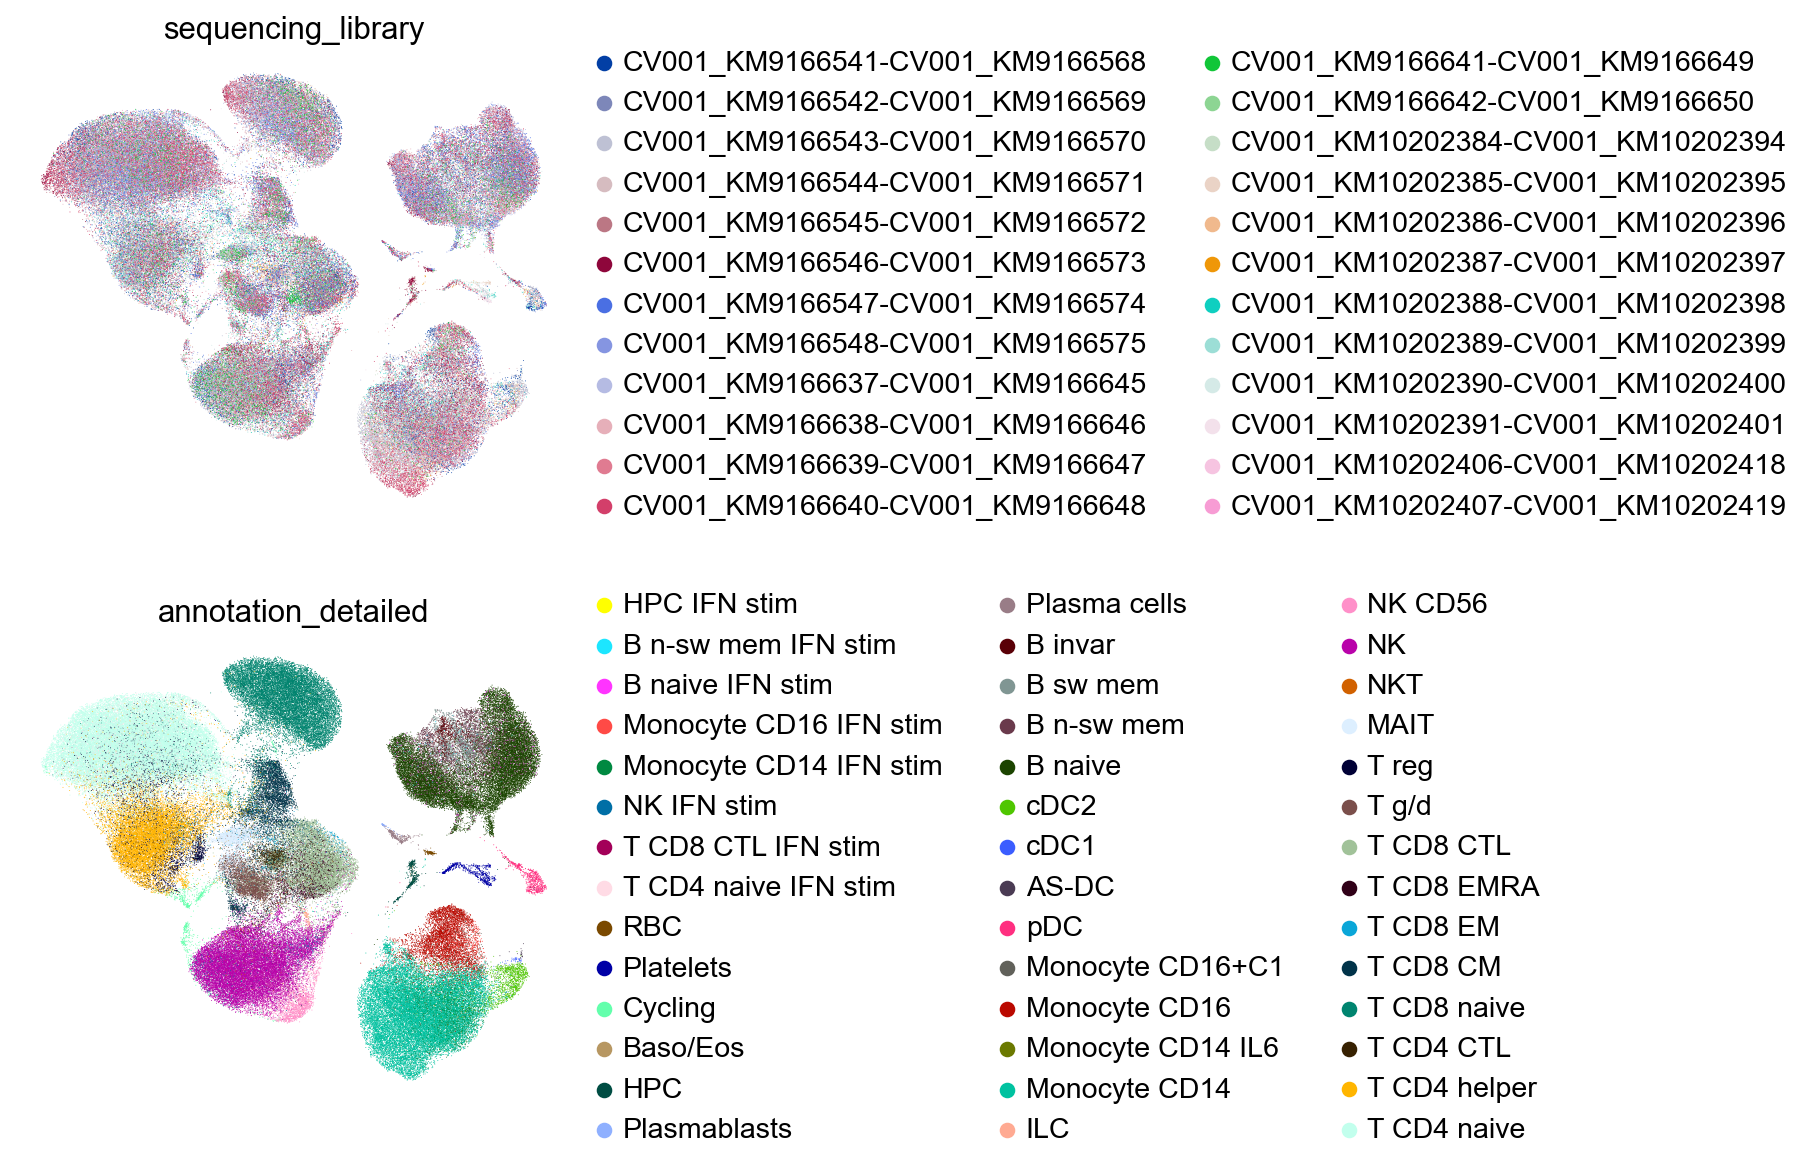

In [24]:
sc.pl.umap(
    adata_ref_new,
    color=["sequencing_library", "annotation_detailed"],
    frameon=False,
    ncols=1,
)

### Update with query

Question: Do you cluster your query data before entering it into the scanvi model?

In [ ]:
dir_path_scan = "/Volumes/LaCie/data_lake/Mairi_example/processed_files/scanvi/models/"
vae_ref_scanvi.save(dir_path_scan, overwrite=True)

In [ ]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(adata_query, dir_path_scan)

In [ ]:
vae_q = scvi.model.SCANVI.load_query_data(
    adata_query,
    dir_path_scan,
)

In [ ]:
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

In [ ]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

In [ ]:
df = adata_query.obs.groupby(["celltype", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

### Analyze reference and query

In [ ]:
adata_full = adata_query.concatenate(adata_ref)

In [ ]:
adata_full.obs.batch.cat.rename_categories(["Query", "Reference"], inplace=True)

In [ ]:
full_predictions = vae_q.predict(adata_full)
print(f"Acc: {np.mean(full_predictions == adata_full.obs.celltype)}")

adata_full.obs["predictions"] = full_predictions

In [ ]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

In [ ]:
sc.pl.umap(
    adata_full,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

In [ ]:
ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["predictions"],
    frameon=False,
    title="Query predictions",
    ax=ax,
    alpha=0.7,
)

ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["celltype"],
    frameon=False,
    title="Query observed cell types",
    ax=ax,
    alpha=0.7,
)